# EVALUATION NOTEBOOK

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                                precision_recall_curve, roc_curve)
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_csv('X_train_pca.csv')
X_test = pd.read_csv('X_test_pca.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [5]:
# Load models
models = {
    'Tuned LR + SMOTE': joblib.load('tuned_lr_smote.pkl'),
    'Tuned RF + SMOTE': joblib.load('tuned_rf_smote.pkl'),
    'Tuned XGB + SMOTE/Optuna': joblib.load('tuned_xgb_smote_optuna.pkl'),
    'Stacking Ensemble': joblib.load('stacking_with_voting.pkl')
}

In [6]:
preds = {}
for name, model in models.items():
    if hasattr(model, 'named_steps'):
        est = model.named_steps['model']
    else:
        est = model
    preds[name] = {
        'pred': est.predict(X_test),
        'proba': est.predict_proba(X_test)[:, 1]
    }

print(f"Loaded—shapes: {X_test.shape}, Models: {len(models)}")

Loaded—shapes: (967, 6), Models: 4


# METRICS TABLE & CONFUSION MATRICES

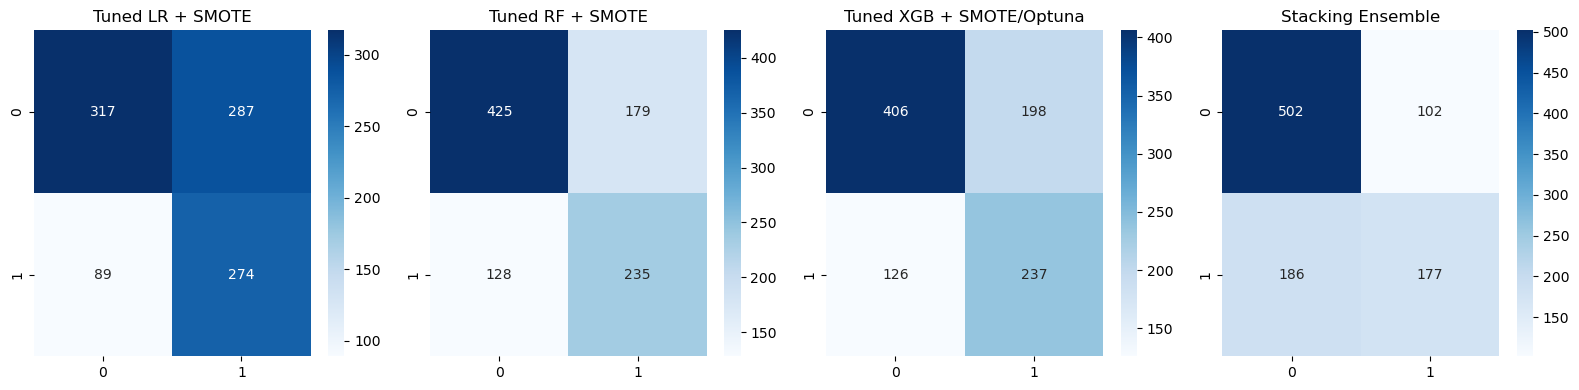

Metrics:
                           F1 Macro  Precision Pos  Recall Pos    AUC    Acc
Tuned LR + SMOTE             0.610          0.488       0.755  0.696  0.611
Tuned RF + SMOTE             0.670          0.568       0.647  0.753  0.683
Tuned XGB + SMOTE/Optuna     0.654          0.545       0.653  0.738  0.665
Stacking Ensemble            0.664          0.634       0.488  0.754  0.702


In [7]:
metrics_df = pd.DataFrame()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (name, data) in enumerate(preds.items()):
    y_pred = data['pred']
    y_proba = data['proba']
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    acc = (y_pred == y_test).mean()
    
    metrics_row = pd.DataFrame({
        'F1 Macro': [report['macro avg']['f1-score']],
        'Precision Pos': [report['1']['precision']],
        'Recall Pos': [report['1']['recall']],
        'AUC': [auc],
        'Acc': [acc]
    }, index=[name])
    metrics_df = pd.concat([metrics_df, metrics_row])
    
    # CM
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

print("Metrics:\n", metrics_df.round(3))

## ROC & PR CURVE

C:\Users\uzebk\AppData\Local\Temp\ipykernel_5328\1212402997.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(rec, prec)
C:\Users\uzebk\AppData\Local\Temp\ipykernel_5328\1212402997.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(rec, prec)
C:\Users\uzebk\AppData\Local\Temp\ipykernel_5328\1212402997.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(rec, prec)
C:\Users\uzebk\AppData\Local\Temp\ipykernel_5328\1212402997.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(rec, prec)


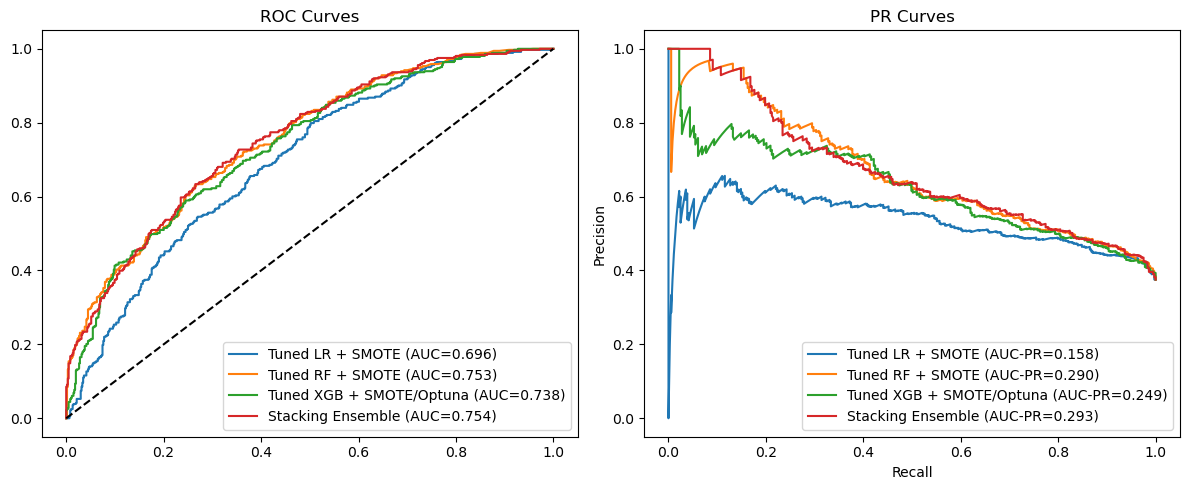

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for name, data in preds.items():
    y_proba = data['proba']
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
    
    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = np.trapz(rec, prec)
    ax2.plot(rec, prec, label=f'{name} (AUC-PR={auc_pr:.3f})')

ax1.plot([0,1], [0,1], 'k--'); ax1.legend(); ax1.set_title('ROC Curves')
ax2.legend(); ax2.set_title('PR Curves'); ax2.set_xlabel('Recall'); ax2.set_ylabel('Precision')
plt.tight_layout()
plt.show()

## Some Predictions from test set

In [10]:
np.random.seed(42)
sample_idx = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test.iloc[sample_idx].reset_index(drop=True)
y_true_sample = y_test.iloc[sample_idx].reset_index(drop=True)

# Use Stacking (best)
model = models['Stacking Ensemble']
if hasattr(model, 'named_steps'):
    est = model.named_steps['model']
else:
    est = model

y_pred_sample = est.predict(X_sample)
y_proba_sample = est.predict_proba(X_sample)[:, 1]
y_pred_thresh = (y_proba_sample > 0.3).astype(int)  # Tweak for recall

results_df = pd.DataFrame({
    'Index': sample_idx,
    'True Label': y_true_sample,
    'Predicted (0.5)': y_pred_sample,
    'Prob High Pop': y_proba_sample.round(3),
    'Predicted (0.3)': y_pred_thresh,
    'Correct (0.5)?': ['Yes' if p == t else 'No' for p, t in zip(y_pred_sample, y_true_sample)],
    'Correct (0.3)?': ['Yes' if p == t else 'No' for p, t in zip(y_pred_thresh, y_true_sample)]
})

print("10 Sample Predictions:")
print(results_df)

sample_acc_05 = (y_pred_sample == y_true_sample).mean()
sample_acc_03 = (y_pred_thresh == y_true_sample).mean()
print(f"\nSample Acc (0.5): {sample_acc_05:.3f} ({sample_acc_05*100:.1f}%)")
print(f"Sample Acc (0.3): {sample_acc_03:.3f} ({sample_acc_03*100:.1f}%)")

# Full test
y_pred_full = est.predict(X_test)
full_acc = (y_pred_full == y_test).mean()
print(f"Full Test Acc: {full_acc:.3f} ({full_acc*100:.1f}%)")

10 Sample Predictions:
   Index  True Label  Predicted (0.5)  Prob High Pop  Predicted (0.3)  \
0    244           1                1          0.783                1   
1    467           0                0          0.261                0   
2    836           0                0          0.379                1   
3    557           0                0          0.257                0   
4     70           0                0          0.226                0   
5    314           0                1          0.677                1   
6    922           0                0          0.369                1   
7    787           1                0          0.402                1   
8     88           1                1          0.774                1   
9    665           0                0          0.353                1   

  Correct (0.5)? Correct (0.3)?  
0            Yes            Yes  
1            Yes            Yes  
2            Yes             No  
3            Yes            Yes  
4  

# QUICK SUMMARY

Overall Summary (Test Only):
                           F1 Macro  Precision Pos  Recall Pos    AUC    Acc
Tuned LR + SMOTE             0.610          0.488       0.755  0.696  0.611
Tuned RF + SMOTE             0.670          0.568       0.647  0.753  0.683
Tuned XGB + SMOTE/Optuna     0.654          0.545       0.653  0.738  0.665
Stacking Ensemble            0.664          0.634       0.488  0.754  0.702


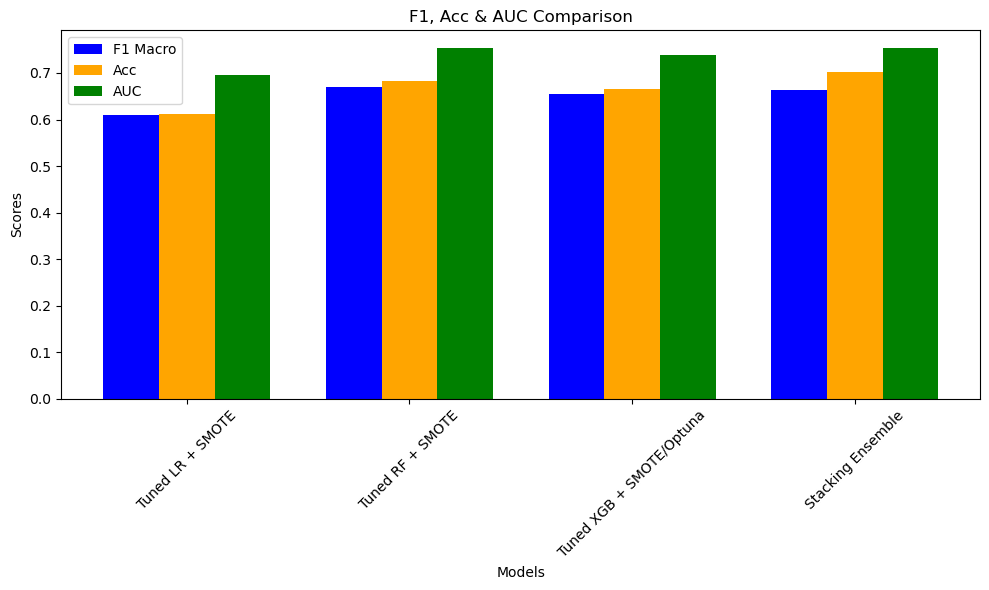

Eval complete—Stacking leads!


In [12]:
summary = metrics_df.round(3)
print("Overall Summary (Test Only):\n", summary)

# Plot: F1, Acc, AUC
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(summary))
width = 0.25

ax.bar(x - width, summary['F1 Macro'], width, label='F1 Macro', color='blue')
ax.bar(x, summary['Acc'], width, label='Acc', color='orange')
ax.bar(x + width, summary['AUC'], width, label='AUC', color='green')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('F1, Acc & AUC Comparison')
ax.set_xticks(x)
ax.set_xticklabels(summary.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

summary.to_csv('eval_summary.csv')
print("Eval complete—Stacking leads!")